In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
from tqdm.notebook import tqdm

In [2]:
# Cursor parking space

In [3]:
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "./project.ipynb"

import wandb
wandb.login()

# wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})
def init_wandb(model, loss_function):
    wandb.init(project="Project", name="Wednesday", entity="cpl57")
    wandb.watch(model, loss_function, log="all")




wandb: Currently logged in as: barisimre (cpl57). Use `wandb login --relogin` to force relogin


In [4]:
patient_folders = ["data/training/" + x + "/" for x in os.listdir("data/training")]
patient_files = [[x + y[:-7] for y in os.listdir(x) if "frame" in y and "gt" not in y] for x in patient_folders]
patient_files_flattened = [element for sublist in patient_files for element in sublist]


images = [{'img': x} for x in patient_files_flattened]

In [5]:
from eval import load_nii
class LoadNIFTI(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        img_file = sample['img'] + ".nii.gz"
        img_mask = sample['img'] + "_gt.nii.gz"
        
        image, img_affine, img_header = load_nii(img_file)
        image = np.moveaxis(image, (2), (0))
        
        mask, mask_affine, mask_header = load_nii(img_mask)
        mask = np.moveaxis(mask, (2), (0))
        
        return {'img': image, 'mask': mask, 'name': sample}
    
    
class SplitMask(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        mask = sample['mask'][0]
            
        c2 = np.where(np.logical_and(mask > 0.2, mask < 0.5), 1.0, 0.0)
        c3 = np.where(np.logical_and(mask > 0.5, mask < 0.8), 1.0, 0.0)
        c4 = np.where(mask > 0.8, 1.0, 0.0)
        sample['mask'] = np.array([c2, c3, c4])
        
        return sample
    
    


In [6]:
# Define transforms for loading the dataset

# add_channels_transform = monai.transforms.AddChanneld(keys=['img', 'mask'])
# flip_transform = monai.transforms.RandFlipd(keys=['img', 'mask'], prob=1, spatial_axis=1)
# rotate_transform = monai.transforms.RandRotated(keys=['img', 'mask'], range_x=np.pi/4, prob=1, mode=['bilinear', 'nearest'])

compose_transform = monai.transforms.Compose(
    [
        LoadNIFTI(),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.ScaleIntensityd(keys=['img', 'mask'], minv=0.0, maxv=1.0),
        SplitMask(),
        monai.transforms.Resized(keys=['img', 'mask'], spatial_size=(-1, 200, 200)),
        monai.transforms.SpatialPadd(keys=['img', 'mask'], spatial_size=(16, -1, -1)),
        monai.transforms.RandFlipd(keys=['img', 'mask'], prob=1, spatial_axis=1),
        monai.transforms.RandRotated(keys=['img', 'mask'], range_x=np.pi/4, prob=1, mode=['bilinear', 'nearest']),
        monai.transforms.RandSpatialCropd(keys=['img', 'mask'], roi_size=(16, 128, 128), random_size=False),
        monai.transforms.ScaleIntensityd(keys=['mask'], minv=0.0, maxv=1.0)
    ]
)


In [7]:
train_dict_list = [x for x in images]
dataset = monai.data.CacheDataset(train_dict_list, transform=compose_transform)


Loading dataset: 100%|████████████████████████████████████████████████| 200/200 [00:06<00:00, 31.20it/s]


In [8]:
data_loader = monai.data.DataLoader(dataset, batch_size=6)

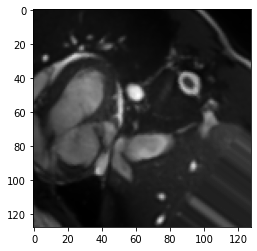

torch.Size([6, 3, 16, 128, 128])


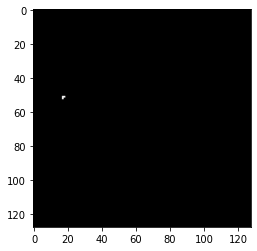

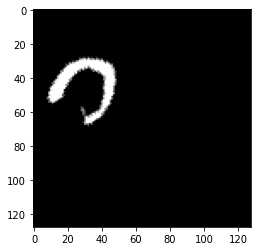

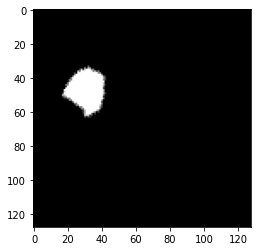

In [9]:
# Visualize something
for data in data_loader:
    plt.imshow(data['img'][0][0][5], cmap='gray')
    plt.show()
    print(data['mask'].shape)
    plt.imshow(data['mask'][0][0][5], cmap='gray')
    plt.show()
    plt.imshow(data['mask'][0][1][5], cmap='gray')
    plt.show()
    plt.imshow(data['mask'][0][2][5], cmap='gray')
    break

In [10]:
# UNet

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# model = monai.networks.nets.UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=3,
#     channels = (8, 16, 32, 64),
#     strides=(1, 1, 1),
#     num_res_units=2,
# ).to(device)

model = monai.networks.nets.UNETR(in_channels=1, out_channels=3, img_size=(16,128,128), feature_size=32, norm_name='batch').to(device)

In [13]:
loss_function =  monai.losses.DiceLoss(sigmoid=False, batch=False)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
import time
run = wandb.init(project="Project", name="Wednesday", entity="cpl57")
wandb.watch(model, loss_function, log_freq=10, log="all")

def flatten(xss):
    return [x for xs in xss for x in xs]

for epoch in tqdm(range(50), colour="pink"):
    train_losses = []
    val_losses = []
    outputs = []
    torch.cuda.empty_cache()

    for data in tqdm(data_loader, colour="pink"):
        img = data['img']
        mask = data['mask']
        model.train()
        optimizer.zero_grad()
        output = torch.clamp(model(img.to(device)), min=0, max=1)
        loss = loss_function(output, mask.to(device))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        run.log( {'loss':loss.item()})



    images = [wandb.Image(x, caption="Input") for x in img.detach().cpu().numpy()[0][0]] 
    labels = flatten([[wandb.Image(channel, caption="Label") for channel in x] for x in mask.detach().cpu().numpy()[0]])           
    masks = flatten([[wandb.Image(channel, caption="Output") for channel in x] for x in output.detach().cpu().numpy()[0]])   


    train_loss = sum(train_losses)/len(train_losses)
    # val_loss = sum(val_losses)/len(val_losses)
    run.log({'label': labels, 'mask': masks,'img': images,'epoch':epoch, 'train_loss': train_loss})   
    
run.finish()
torch.save(model.state_dict(), f'models/trainedUNet{str(time.time())}.pt')
    


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]